# Intro

Simple starter notebook for [Hotel-ID to Combat Human Trafficking 2022 - FGVC9](https://www.kaggle.com/competitions/hotel-id-to-combat-human-trafficking-2022-fgvc9) competition using classification model. This notebook uses preprocessed images that were resized and padded to 256x256 pixel. 

Used dataset: [Hotel-ID 2022 train images 256x256](https://www.kaggle.com/datasets/michaln/hotelid-2022-train-images-256x256) created by [Hotel-ID - image preprocessing - 256x256](https://www.kaggle.com/code/michaln/hotel-id-image-preprocessing-256x256) notebook.

Classification model might not be very useful in real life application because it will not be able to handle new hotels without retraining. You can find better approaches in last year competition [Hotel-ID to Combat Human Trafficking 2021 - FGVC8](https://www.kaggle.com/competitions/hotel-id-2021-fgvc8):
- [1st place solution: Swin + Arcface + Label-constrained DBA](https://www.kaggle.com/c/hotel-id-2021-fgvc8/discussion/242087)
- [8th place solution: arcface + cosface + classification](https://www.kaggle.com/c/hotel-id-2021-fgvc8/discussion/242207)
- [14th place solution - fastai ensemble](https://www.kaggle.com/c/hotel-id-2021-fgvc8/discussion/242030)

# Imports

In [1]:
!pip install timm

     |████████████████████████████████| 431 kB 924 kB/s            


In [2]:
import numpy as np
import pandas as pd
import random
import os

In [3]:
from PIL import Image as pil_image
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import timm

# Global

In [5]:
IMG_SIZE = 256
SEED = 42
N_MATCHES = 5

PROJECT_FOLDER = "../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/"
DATA_FOLDER = "../input/hotelid-2022-train-images-256x256/"
IMAGE_FOLDER = DATA_FOLDER + "images/"
OUTPUT_FOLDER = ""

train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))

In [6]:
print(os.listdir(PROJECT_FOLDER))

['sample_submission.csv', 'train_images', 'train_masks', 'test_images']


In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Dataset and transformations

Coarse dropout with fill_value=(255,0,0) (full red channel) is used to simulate the occlussions like the one in test dataset. 
```python
A.CoarseDropout(p=0.75, max_holes=1, 
                min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                fill_value=(255,0,0))
```

In [8]:
import albumentations as A
import albumentations.pytorch as APT
import cv2 

# used for training dataset - augmentations and occlusions
train_transform = A.Compose([
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.25),
    A.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.OpticalDistortion(p=0.25),
    A.Perspective(p=0.25),
    A.CoarseDropout(p=0.5, min_holes=1, max_holes=6, 
                    min_height=IMG_SIZE//16, max_height=IMG_SIZE//4,
                    min_width=IMG_SIZE//16,  max_width=IMG_SIZE//4), # normal coarse dropout
    
    A.CoarseDropout(p=0.75, max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions in test data

    A.RandomBrightnessContrast(p=0.75),
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# used for validation dataset - only occlusions
val_transform = A.Compose([
    A.CoarseDropout(p=0.75, max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# no augmentations
base_transform = A.Compose([
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

In [9]:
class HotelTrainDataset:
    def __init__(self, data, transform=None, data_path="train_images/"):
        self.data = data
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        record = self.data.iloc[idx]
        image_path = self.data_path + record["image_id"]
        image = np.array(pil_image.open(image_path)).astype(np.uint8)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        
        return {
            "image" : image,
            "target" : record['hotel_id_code'],
        }

# Model

In [10]:
class HotelIdModel(nn.Module):
    def __init__(self, n_classes=100, backbone_name="efficientnet_b0"):
        super(HotelIdModel, self).__init__()
        
        self.backbone = timm.create_model(backbone_name, num_classes=n_classes, pretrained=True)

    def forward(self, x):
        return self.backbone(x)

# Model helper functions

In [11]:
def save_checkpoint(model, scheduler, optimizer, epoch, name, loss=None, score=None):
    checkpoint = {"epoch": epoch,
                  "model": model.state_dict(),
                  "scheduler": scheduler.state_dict(),
                  "optimizer": optimizer.state_dict(),
                  "loss": loss,
                  "score": score,
                  }

    torch.save(checkpoint, f"{OUTPUT_FOLDER}checkpoint-{name}.pt")


def load_checkpoint(model, scheduler, optimizer, name):
    checkpoint = torch.load(f"{OUTPUT_FOLDER}checkpoint-{name}.pt")

    model.load_state_dict(checkpoint["model"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    return model, scheduler, optimizer, checkpoint["epoch"]

# Train functions

In [12]:
def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = []
    targets_all = []
    outputs_all = []
    
    model.train()
    t = tqdm(loader)
    
    for i, sample in enumerate(t):
        optimizer.zero_grad()
        
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
                
        losses.append(loss.item())
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())

        score = np.mean(targets_all == np.argmax(outputs_all, axis=1))
        desc = f"Epoch {epoch}/{args.epochs} - Train loss:{loss:0.4f}, accuracy: {score:0.4f}"
        t.set_description(desc)
        
    return np.mean(losses), score


def test(loader, model):
    targets_all = []
    outputs_all = []
    
    model.eval()
    t = tqdm(loader)
    
    for i, sample in enumerate(t):
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        outputs = model(images)
        
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        
    
    # repeat targets to N_MATCHES for easy calculation of MAP@5
    y = np.repeat([targets_all], repeats=N_MATCHES, axis=0).T
    # sort predictions and get top 5
    preds = np.argsort(-np.array(outputs_all), axis=1)[:, :5]
    # check if any of top 5 predictions are correct and calculate mean accuracy
    acc_top_5 = (preds == y).any(axis=1).mean()
    # calculate prediction accuracy
    acc_top_1 = np.mean(targets_all == np.argmax(outputs_all, axis=1))

    print(f"Accuracy: {acc_top_1:0.4f}, MAP@5: {acc_top_5:0.4f}")

# Prepare data

In [13]:
data_df = pd.read_csv(DATA_FOLDER + "train.csv")
# encode hotel ids
data_df["hotel_id_code"] = data_df["hotel_id"].astype('category').cat.codes.values.astype(np.int64)

In [14]:
# save hotel_id encoding for later decoding
hotel_id_code_df = data_df.drop(columns=["image_id"]).drop_duplicates().reset_index(drop=True)
hotel_id_code_df.to_csv(OUTPUT_FOLDER + 'hotel_id_code_mapping.csv', index=False)
# hotel_id_code_map = hotel_id_code_df.set_index('hotel_id_code').to_dict()["hotel_id"]

# Quick look at data

We can see that most hotels have less than 20 images while there are few with over hundreds and one with over 1000. In case of classification weights or sampling might be useful to handle the imbalance.

## Image count per hotel

In [15]:
group_df = data_df.groupby(["hotel_id"]).size().to_frame("image_count").sort_values("image_count")[::-1].reset_index()

# top and low
low_df = group_df.iloc[-50:]
top_df = group_df.iloc[:50]

fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"colspan": 2}, None], [{}, {}]],
                    horizontal_spacing=0.02, vertical_spacing=0.2, 
                    shared_yaxes=False,
                    subplot_titles=("", "Top 50", "Bottom 50"))


fig.add_trace(go.Scatter(x=group_df["hotel_id"], y=group_df["image_count"], showlegend = False), 1, 1)
fig.add_trace(go.Bar(x=top_df["hotel_id"], y=top_df["image_count"], showlegend = False), 2, 1)
fig.add_trace(go.Bar(x=low_df["hotel_id"], y=low_df["image_count"], showlegend = False), 2, 2)

fig.update_yaxes(title_text="Image count", row=1, col=1)
fig.update_yaxes(title_text="Image count", row=2, col=1)
fig.update_xaxes(type="category", visible=False, row=1, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=2)

fig.update_layout(title="Image count per hotel", height=550)
fig.show()

In [16]:
fig = px.histogram(group_df, x="image_count", nbins=100, marginal="box", height=350)
fig.update_layout(title="Distribution of image count per hotel")
fig.update_traces(hovertemplate="Image count: %{x} <br>Hotel count: %{y}")
fig.show()

## Example of images

In [17]:
def show_images(ds, title_text, n_images=5):
    fig, ax = plt.subplots(1,5, figsize=(22,8))
    
    ax[0].set_ylabel(title_text)
    
    for i in range(5):
        d = ds.__getitem__(i)
        ax[i].imshow(d["image"].T)

### Train images without and with augmentations

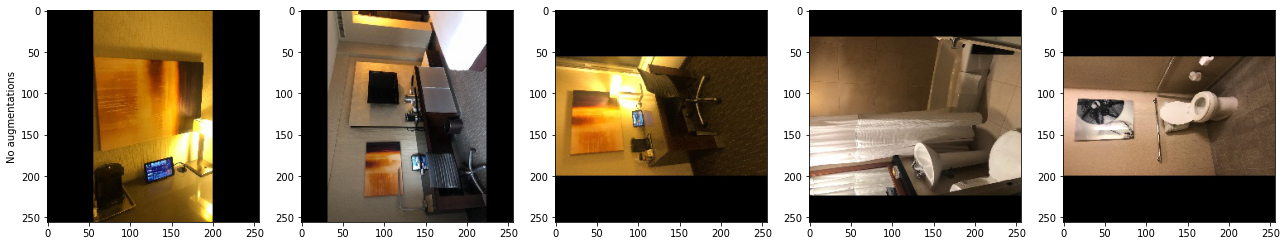

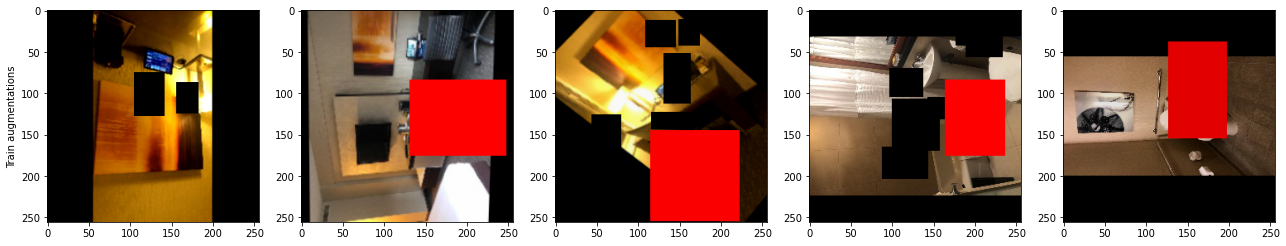

In [18]:
train_dataset = HotelTrainDataset(data_df, base_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'No augmentations')

train_dataset = HotelTrainDataset(data_df, train_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'Train augmentations')

### Test image example with occlusion

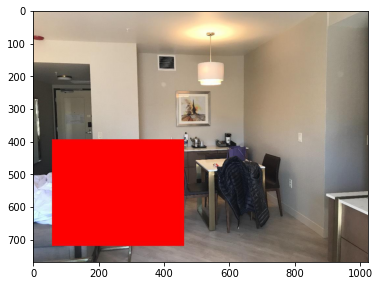

In [19]:
test_image = np.array(pil_image.open('../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/test_images/abc.jpg')).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(test_image)

# Train and evaluate

In [20]:
def train_and_validate(args, data_df):
    model_name = f"classification-model-{args.backbone_name}-{IMG_SIZE}x{IMG_SIZE}"
    print(model_name)

    seed_everything(seed=SEED)

    val_df = data_df.groupby("hotel_id").sample(args.val_samples, random_state=SEED)
    train_df = data_df[~data_df["image_id"].isin(val_df["image_id"])]

    train_dataset = HotelTrainDataset(train_df, train_transform, data_path=IMAGE_FOLDER)
    train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)
    val_dataset = HotelTrainDataset(val_df, val_transform, data_path=IMAGE_FOLDER)
    valid_loader = DataLoader(val_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)

    model = HotelIdModel(args.n_classes, args.backbone_name)
    model = model.to(args.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
                    optimizer,
                    max_lr=args.lr,
                    epochs=args.epochs,
                    steps_per_epoch=len(train_loader),
                    div_factor=10,
                    final_div_factor=1,
                    pct_start=0.1,
                    anneal_strategy="cos",
                )
    
    start_epoch = 1
    
    for epoch in range(start_epoch, args.epochs+1):
        train_loss, train_score = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        save_checkpoint(model, scheduler, optimizer, epoch, model_name, train_loss, train_score)
        test(valid_loader, model)

## Efficientnet-b0 training

In [21]:
%%time 

class args:
    epochs = 5
    lr = 1e-3
    batch_size = 64
    num_workers = 2
    val_samples = 1
    backbone_name = "efficientnet_b0"
    n_classes = data_df["hotel_id_code"].nunique()
    device = ('cuda' if torch.cuda.is_available() else 'cpu')

train_and_validate(args, data_df)

classification-model-efficientnet_b0-256x256


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
100%|██████████| 49/49 [00:12<00:00,  4.03it/s]


Accuracy: 0.0375, MAP@5: 0.0902


100%|██████████| 49/49 [00:09<00:00,  5.17it/s]


Accuracy: 0.1845, MAP@5: 0.3431


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]


Accuracy: 0.3322, MAP@5: 0.5177


100%|██████████| 49/49 [00:08<00:00,  5.67it/s]


Accuracy: 0.4117, MAP@5: 0.5818


100%|██████████| 49/49 [00:09<00:00,  5.27it/s]


Accuracy: 0.4358, MAP@5: 0.6091
CPU times: user 19min 14s, sys: 7min 17s, total: 26min 31s
Wall time: 29min 36s
